# <u>Mini Classification Project</u>

**Name**: Weeranut Chayakul <br>
**Student ID**: 6510405806

## Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read csv file
df = pd.read_csv("fertility2.csv")

# show some examples
df.sample(5)

,Age,kidney diseases,Fasting Blood sugar,Uri infection,exercise habit,Frequency of alcohol consumption,Smoking habit,profession,#hours spent sitting per day,Diagnosis
129,36,yes,94,yes,no,several times a week,occasional,engineer,5,Normal
93,32,yes,160,yes,less than 3 hours a week,once a week,never,accountant,8,weak
22,30,yes,99,no,more than 3 months ago,once a week,never,programmer,5,Normal
58,28,yes,94,no,less than 3 hours a week,every day,daily,engineer,11,weak
72,28,yes,82,no,less than 3 hours a week,several times a week,occasional,pilot,9,weak


In [3]:
# show number of rows and columns
print(df.shape)

(139, 10)


## Preprocessing

In [4]:
# check nan value in data
df.isna().sum()

Age                                 0
kidney diseases                     0
Fasting Blood sugar                 0
Uri infection                       0
exercise habit                      0
Frequency of alcohol consumption    0
Smoking habit                       0
profession                          0
#hours spent sitting per day        0
Diagnosis                           0
dtype: int64

#### Count All Possible Value in Column

In [5]:
# count values of each column
cols = df.shape[1]
for i in range(cols):
    print(df.iloc[:,i].value_counts(), end="\n\n")

28    25
30    23
32    16
27     6
33     6
60     5
35     5
29     5
31     3
58     3
62     3
55     3
48     2
63     2
70     2
65     2
44     2
64     2
59     2
34     2
36     2
56     2
66     2
61     1
68     1
51     1
24     1
22     1
39     1
67     1
54     1
50     1
40     1
38     1
42     1
53     1
37     1
Name: Age, dtype: int64

yes    88
no     51
Name: kidney diseases, dtype: int64

94     41
96     11
110    10
91      6
88      6
90      5
89      5
144     4
80      4
99      4
100     4
98      3
130     3
86      3
140     3
160     2
82      2
79      2
87      2
155     2
121     2
150     2
120     2
134     1
95      1
133     1
81      1
200     1
92      1
180     1
85      1
78      1
153     1
145     1
Name: Fasting Blood sugar, dtype: int64

no     75
yes    64
Name: Uri infection, dtype: int64

more than 3 months ago      44
no                          42
less than 3 hours a week    39
no exercise                  8
less than 3 months ago   

In [6]:
# change exercise habit "no" to "no exercise" (same category)
df["exercise habit"] = df["exercise habit"].apply(lambda x: "no exercise" if x == "no" else x)

df.sample(5)

,Age,kidney diseases,Fasting Blood sugar,Uri infection,exercise habit,Frequency of alcohol consumption,Smoking habit,profession,#hours spent sitting per day,Diagnosis
93,32,yes,160,yes,less than 3 hours a week,once a week,never,accountant,8,weak
26,55,yes,133,yes,less than 3 hours a week,several times a week,never,pilot,7,weak
16,56,yes,89,yes,more than 3 months ago,hardly ever or never,never,pilot,7,Normal
17,30,yes,120,yes,less than 3 hours a week,once a week,never,engineer,5,weak
54,29,no,94,yes,more than 3 months ago,hardly ever or never,never,pilot,11,Normal


#### Convert text to number using LabelEncoder

In [7]:
# encode weak to 1 and normal to 0
df["Diagnosis"] = df["Diagnosis"].apply(lambda x: 1 if x == "weak" else 0)

df.sample(5)

,Age,kidney diseases,Fasting Blood sugar,Uri infection,exercise habit,Frequency of alcohol consumption,Smoking habit,profession,#hours spent sitting per day,Diagnosis
94,28,yes,94,no,less than 3 hours a week,several times a week,daily,engineer,9,1
11,32,yes,89,yes,more than 3 months ago,several times a week,occasional,engineer,2,1
131,32,yes,110,no,no exercise,hardly ever or never,daily,engineer,1,0
81,33,no,94,yes,no exercise,once a week,occasional,accountant,3,1
38,30,no,155,yes,less than 3 hours a week,several times a week,occasional,accountant,9,1


In [8]:
# select only string value columns
text_columns = [col for col in df.columns if df[col].dtype == 'O']
for col in text_columns:
    df[col] = LabelEncoder().fit_transform(df[col])
    
df.sample(5)

,Age,kidney diseases,Fasting Blood sugar,Uri infection,exercise habit,Frequency of alcohol consumption,Smoking habit,profession,#hours spent sitting per day,Diagnosis
85,34,0,96,0,0,4,0,2,6,1
0,30,0,80,1,2,2,2,1,16,0
45,28,1,94,0,3,1,2,0,8,1
3,44,0,96,1,2,1,1,2,7,0
116,58,0,94,0,3,0,0,1,11,0


### Control Variables

In [9]:
random_state = 13
test_size = 0.2
cv = 5

### Grid Search Accuracy Plot

In [10]:
def plot_search_results(grid):
    # results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    # getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    # ploting results
    if len(masks) == 1: 
        mask_to_plot = masks_names[0]
        mask_index = masks_names.index(mask_to_plot)

        fig, ax = plt.subplots(1, 1, figsize=(10, 5))  # Use 1 subplot for the specific mask
        fig.suptitle(f'Score per parameter')
        fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')

        x = np.array(params[mask_to_plot])
        y_1 = np.array(means_test)
        e_1 = np.array(stds_test)
        y_2 = np.array(means_train)
        e_2 = np.array(stds_train)

        ax.errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax.errorbar(x, y_2, e_2, linestyle='-', marker='^', label='train')
        
        if isinstance(x[0], (int, float)):
            ax.set_xscale("log")
            
        ax.set_xlabel(mask_to_plot.upper())
        ax.legend()

        plt.show()
    
    else:
        fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
        fig.suptitle('Score per parameter')
        fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
        pram_preformace_in_best = {}
        for i, p in enumerate(masks_names):
                m = np.stack(masks[:i] + masks[i+1:])
                pram_preformace_in_best
                best_parms_mask = m.all(axis=0)
                best_index = np.where(best_parms_mask)[0]
                x = np.array(params[p])
                y_1 = np.array(means_test[best_index])
                e_1 = np.array(stds_test[best_index])
                y_2 = np.array(means_train[best_index])
                e_2 = np.array(stds_train[best_index])
                ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
                ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^', label='train' )
                
                if isinstance(x[0], (int, float)):
                    ax[i].set_xscale("log")
                    
                ax[i].set_xlabel(p.upper())

        plt.legend()
        plt.show()

### Variable Store Accuracy Model

In [11]:
data = {}

## 1. Decision Tree

Best Parameters: {'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 0.4}
Accuracy: 0.8571428571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.73      0.89      0.80         9

    accuracy                           0.86        28
   macro avg       0.83      0.87      0.84        28
weighted avg       0.87      0.86      0.86        28



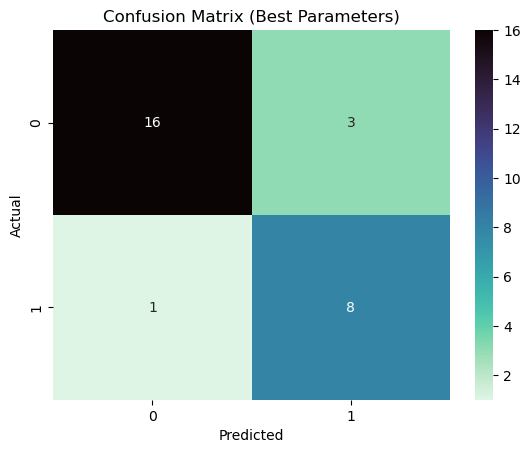

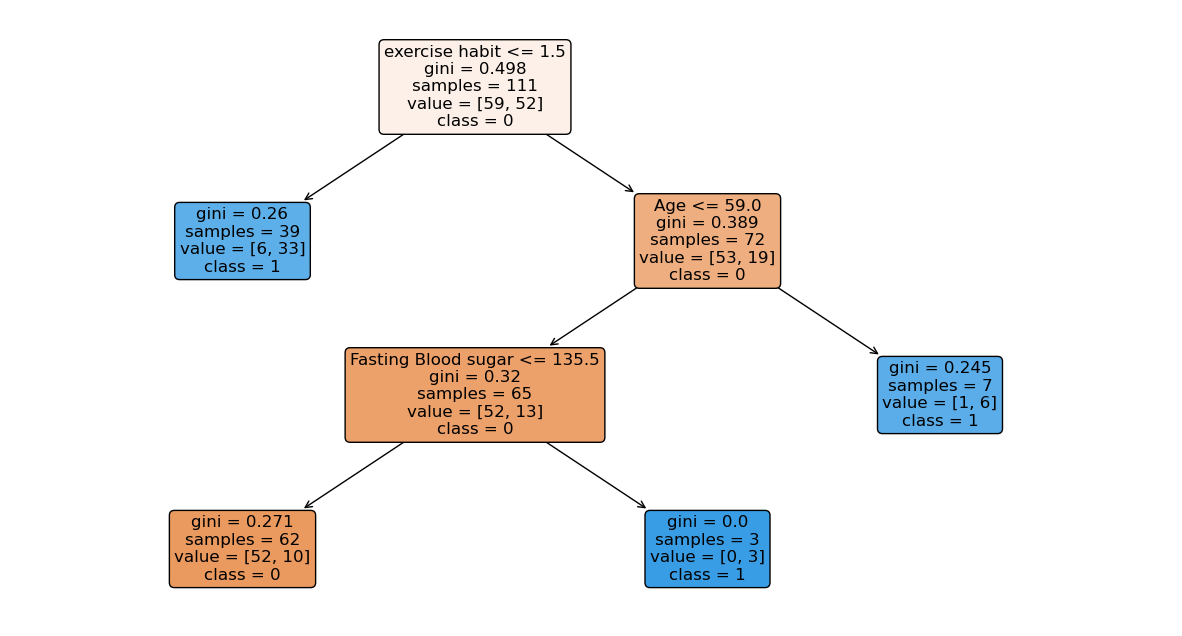

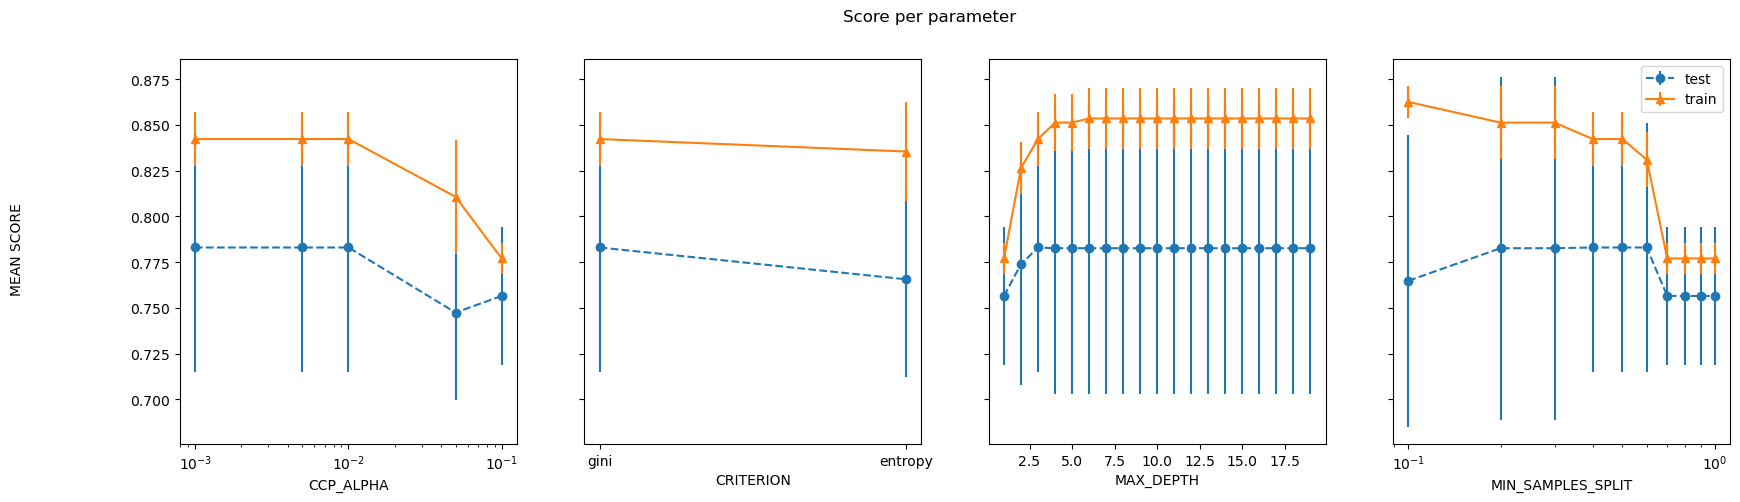

In [12]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(1, 20)],
    'min_samples_split': [i / 100 for i in range(10, 101, 10)],
    'ccp_alpha': [0.1, 0.05, 0.01, 0.005, 0.001],
}

# create decision tree classifier
clf = DecisionTreeClassifier(random_state=random_state)

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)


# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot the best decision tree
plt.figure(figsize=(15, 8))
plot_tree(grid_search.best_estimator_, feature_names=X.columns.tolist(), class_names=[str(c) for c in y.unique()], filled=True, rounded=True, fontsize=12)
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['Decision Tree'] = accuracy_score(y_test, y_pred)

## 2. Support Vector Machine

Best Parameters: {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.8928571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.67      0.80         9

    accuracy                           0.89        28
   macro avg       0.93      0.83      0.86        28
weighted avg       0.91      0.89      0.89        28



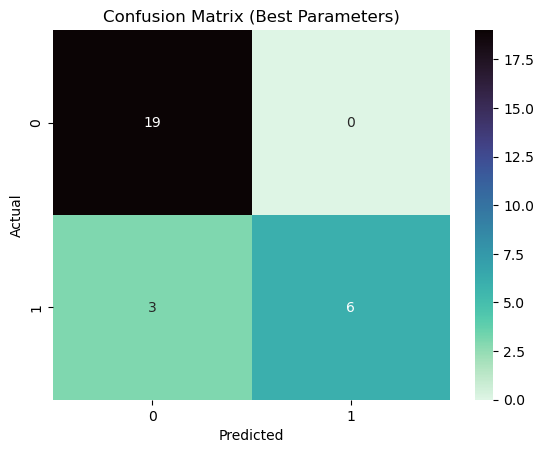

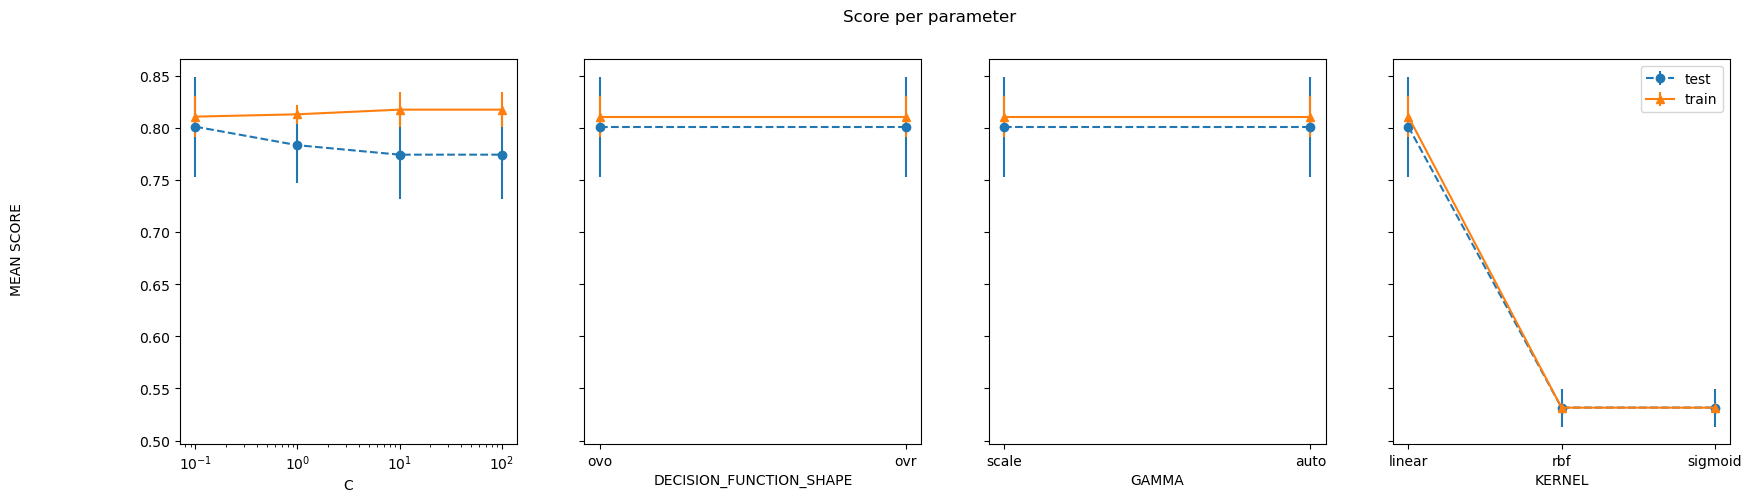

In [13]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr']
}

# create support vector machine classifier
clf = SVC()

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)

# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['Support Vector Machine'] = accuracy_score(y_test, y_pred)

## 3. Naive Bayes

### 3.1 Gaussian Naive Bayes

Best Parameters: {'var_smoothing': 1e-06}
Accuracy: 0.8214285714285714
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       0.64      1.00      0.78         9

    accuracy                           0.82        28
   macro avg       0.82      0.87      0.82        28
weighted avg       0.89      0.82      0.83        28



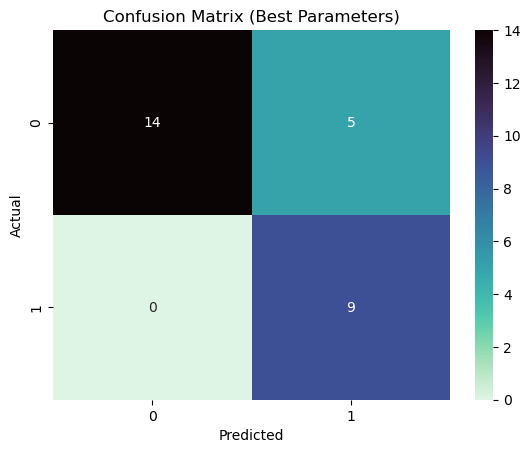

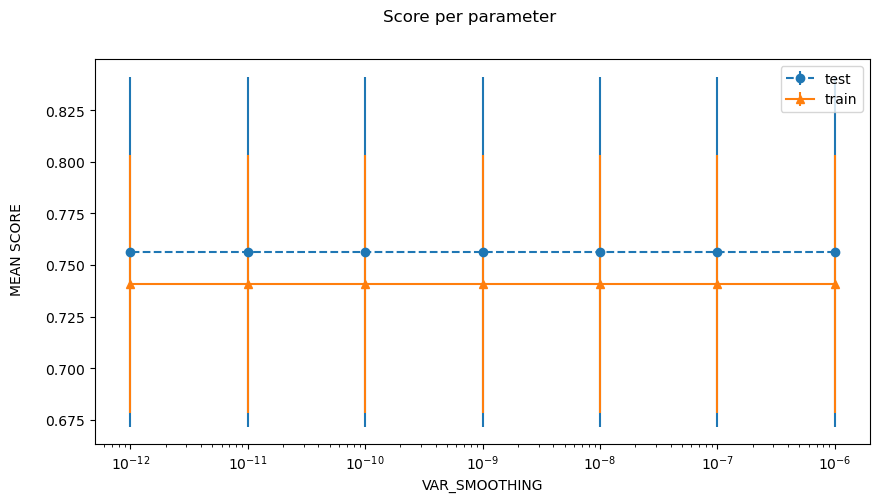

In [14]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'var_smoothing': [1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12],
}

# create gaussian naive bayes classifier
clf = GaussianNB()

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)

# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['Gaussian Naive Bayes'] = accuracy_score(y_test, y_pred)

### 3.2 Bernoulli Naive Bayes

Best Parameters: {'alpha': 0.4, 'binarize': 1.0, 'fit_prior': True}
Accuracy: 0.8214285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.83      0.56      0.67         9

    accuracy                           0.82        28
   macro avg       0.83      0.75      0.77        28
weighted avg       0.82      0.82      0.81        28



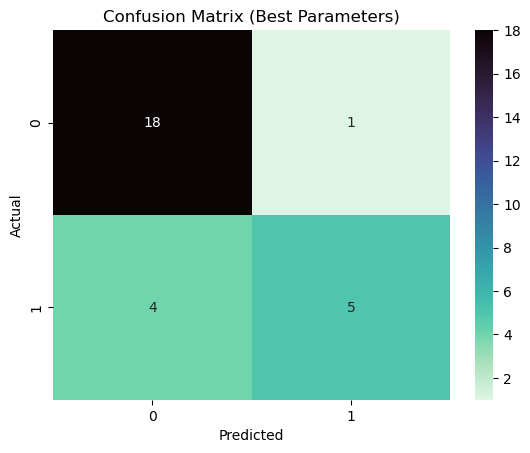

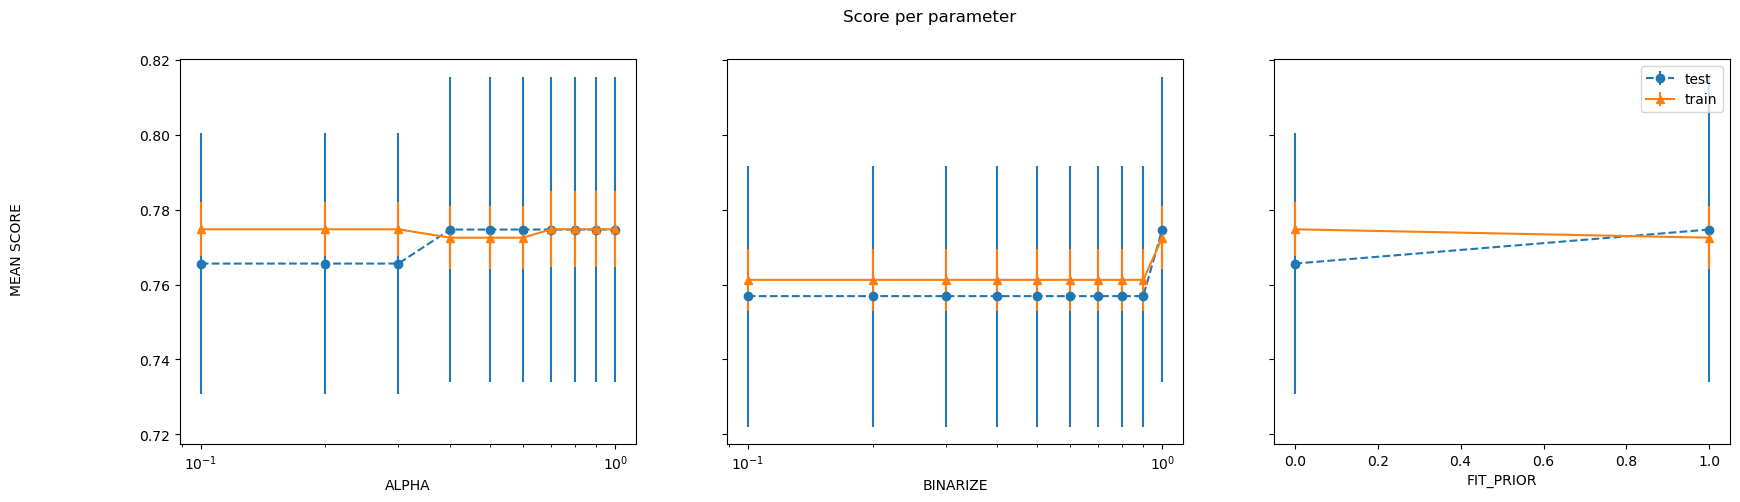

In [15]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'alpha': [i / 100 for i in range(10, 101, 10)],
    'binarize': [i / 100 for i in range(10, 101, 10)],
    'fit_prior': [True, False],
}

# create bernoulli naive bayes classifier
clf = BernoulliNB()

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)

# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['Bernoulli Naive Bayes'] = accuracy_score(y_test, y_pred)

### 3.3 Multinomial Naive Bayes

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.54      0.78      0.64         9

    accuracy                           0.71        28
   macro avg       0.70      0.73      0.70        28
weighted avg       0.76      0.71      0.72        28



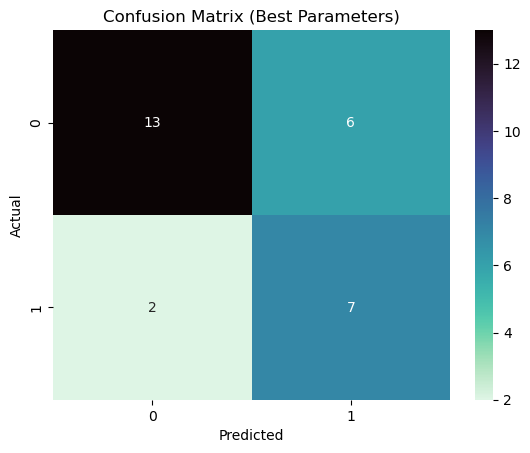

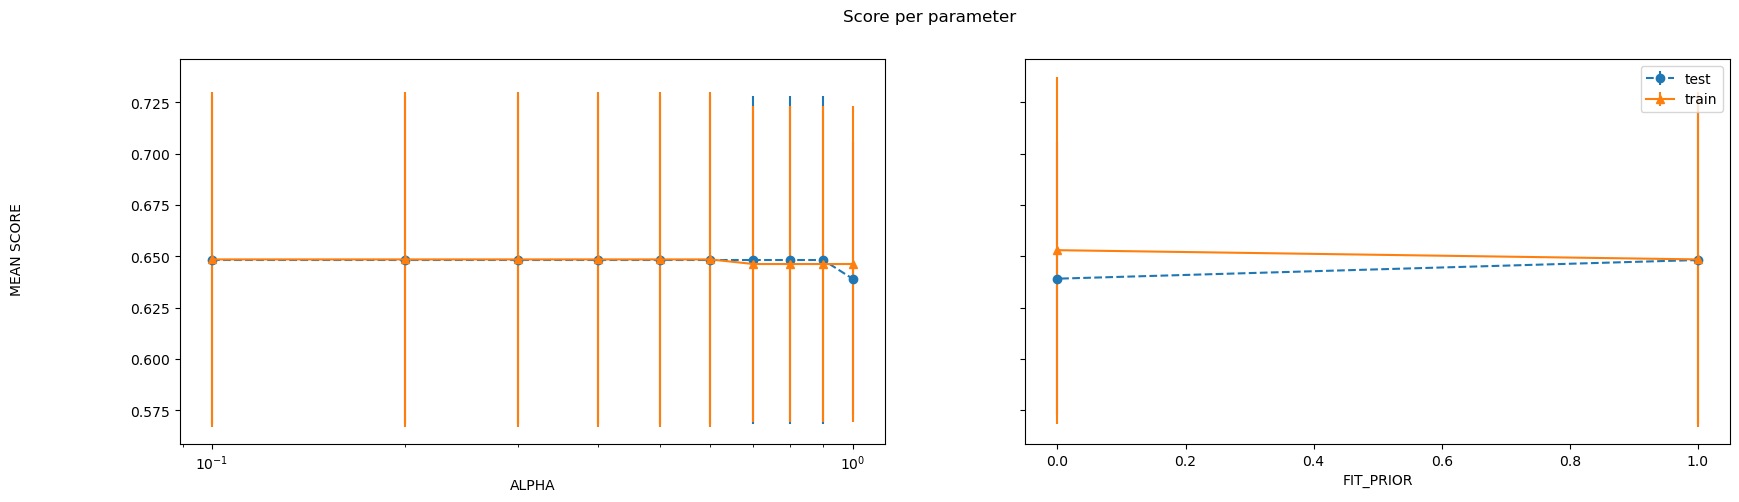

In [16]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'alpha': [i / 100 for i in range(10, 101, 10)],
    'fit_prior': [True, False],
}

# create multinomial naive bayes classifier
clf = MultinomialNB()

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)

# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['Multinomial Naive Bayes'] = accuracy_score(y_test, y_pred)

### 3.4 Complement Naive Bayes

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.54      0.78      0.64         9

    accuracy                           0.71        28
   macro avg       0.70      0.73      0.70        28
weighted avg       0.76      0.71      0.72        28



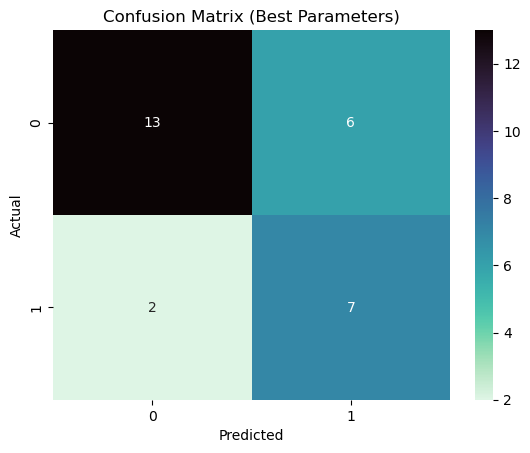

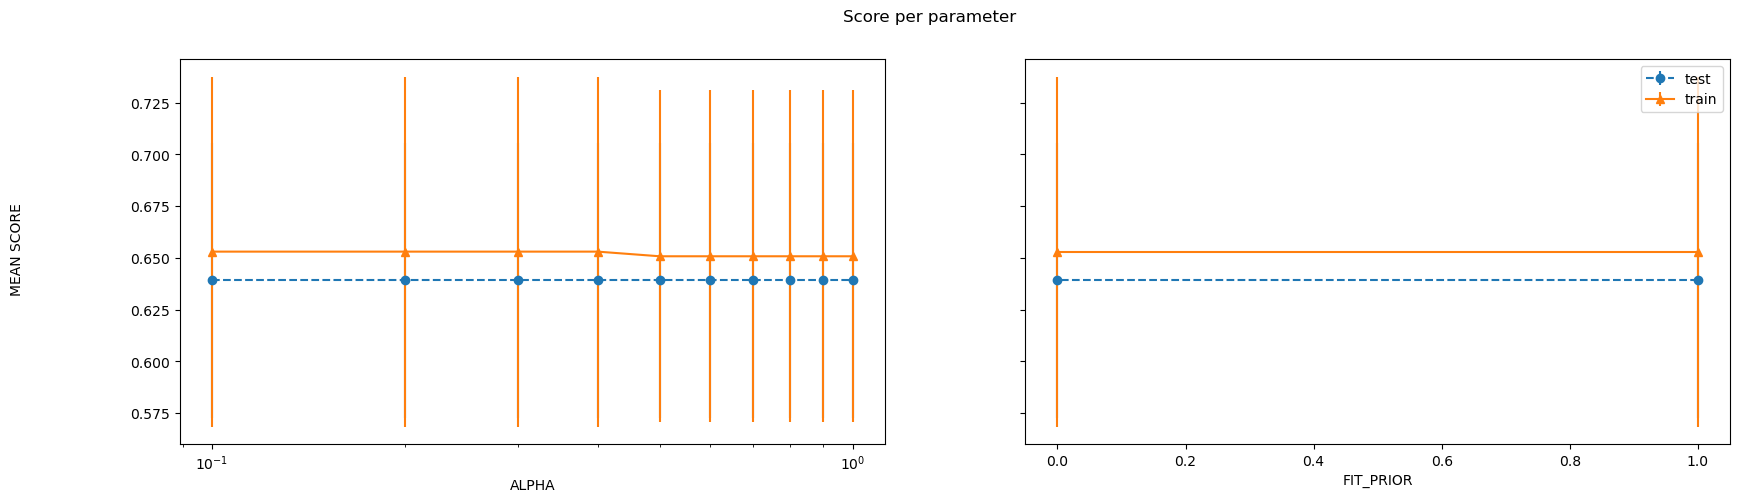

In [17]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'alpha': [i / 100 for i in range(10, 101, 10)],
    'fit_prior': [True, False],
}

# create vomplement naive bayes classifier
clf = ComplementNB()

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)

# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['Complement Naive Bayes'] = accuracy_score(y_test, y_pred)

## 4. K-Nearest Neighbor

Best Parameters: {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy: 0.8928571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.80      0.89      0.84         9

    accuracy                           0.89        28
   macro avg       0.87      0.89      0.88        28
weighted avg       0.90      0.89      0.89        28



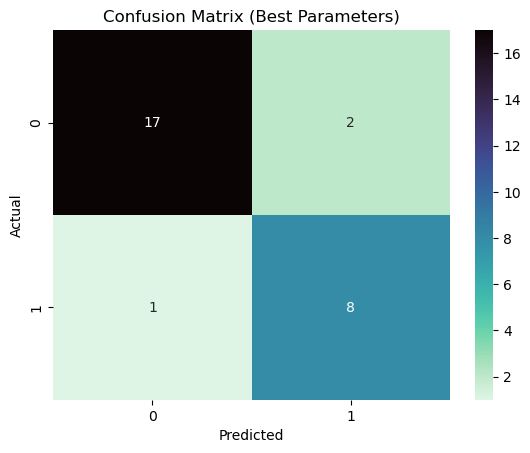

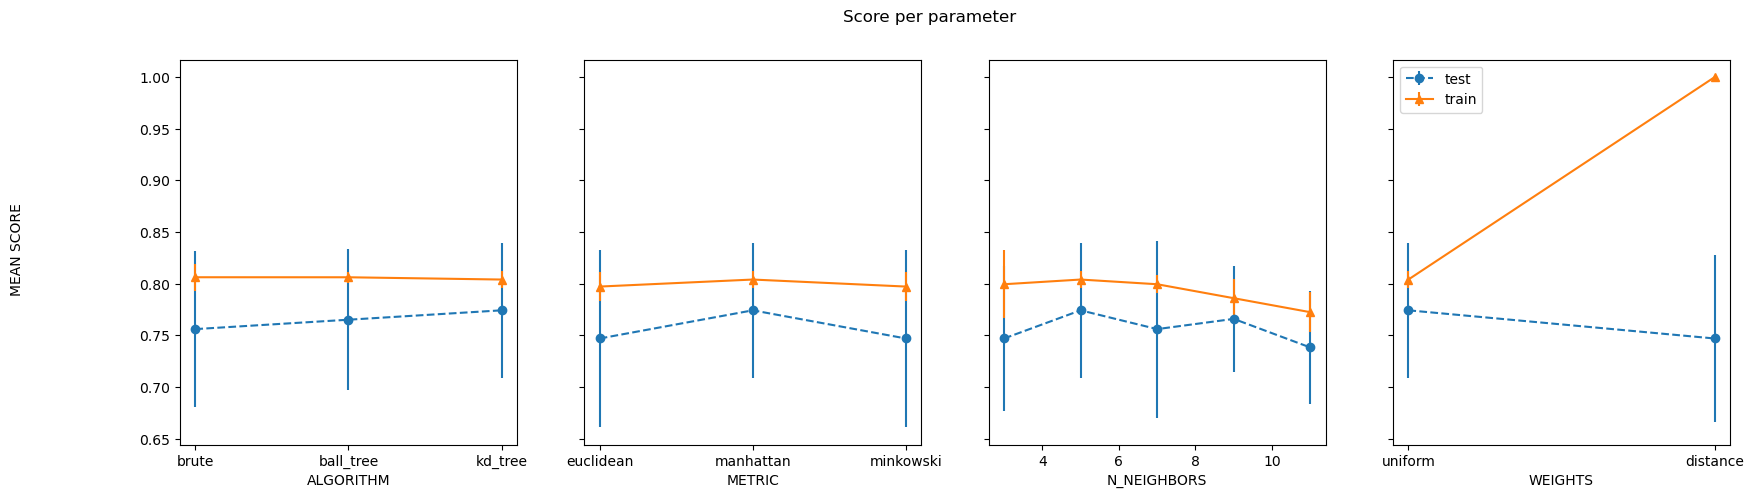

In [18]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'algorithm': ['brute', 'ball_tree', 'kd_tree'],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

# create k-nearest neighbor classifier
clf = KNeighborsClassifier()

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)

# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['K-Nearest Neighbor'] = accuracy_score(y_test, y_pred)

## 5. Logistic Regression

Best Parameters: {'C': 0.1, 'fit_intercept': True, 'multi_class': 'multinomial', 'tol': 0.1}
Accuracy: 0.8928571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.88      0.78      0.82         9

    accuracy                           0.89        28
   macro avg       0.89      0.86      0.87        28
weighted avg       0.89      0.89      0.89        28



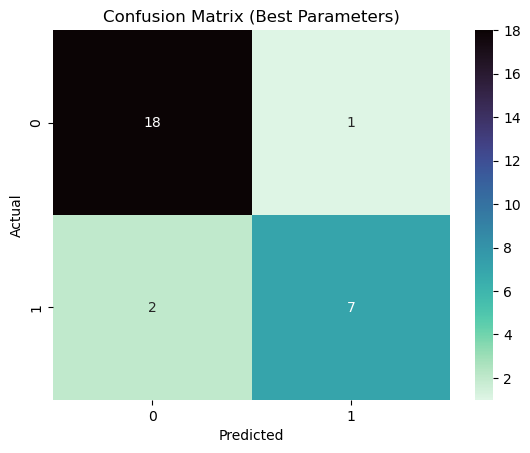

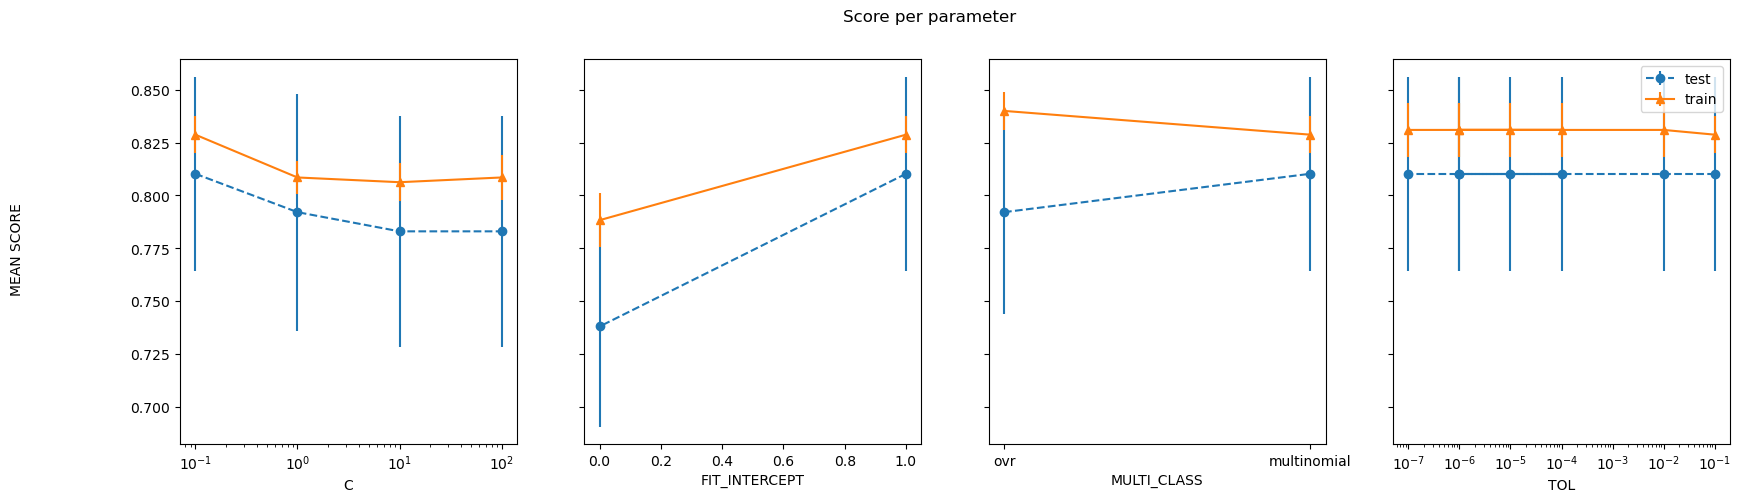

In [19]:
import warnings

# hide warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# feature selection
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# define the parameter grid to search
param_grid = {
    'tol':  [1e-1, 1e-2, 1e-6, 1e-4, 1e-5, 1e-6, 1e-7],
    'C': [0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'multi_class': ['ovr', 'multinomial'],
}

# create logistic regression classifier
clf = LogisticRegression(random_state=random_state, max_iter=1000)

# create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', return_train_score=True)

# fit the model to the data
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# print the best parameters
print("Best Parameters:", best_params)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# display the confusion matrix
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako_r', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Parameters)')
plt.show()

# plot grid search accuracy
plot_search_results(grid_search)

# store accuracy
data['Logistic Regression'] = accuracy_score(y_test, y_pred)

## Conclusion

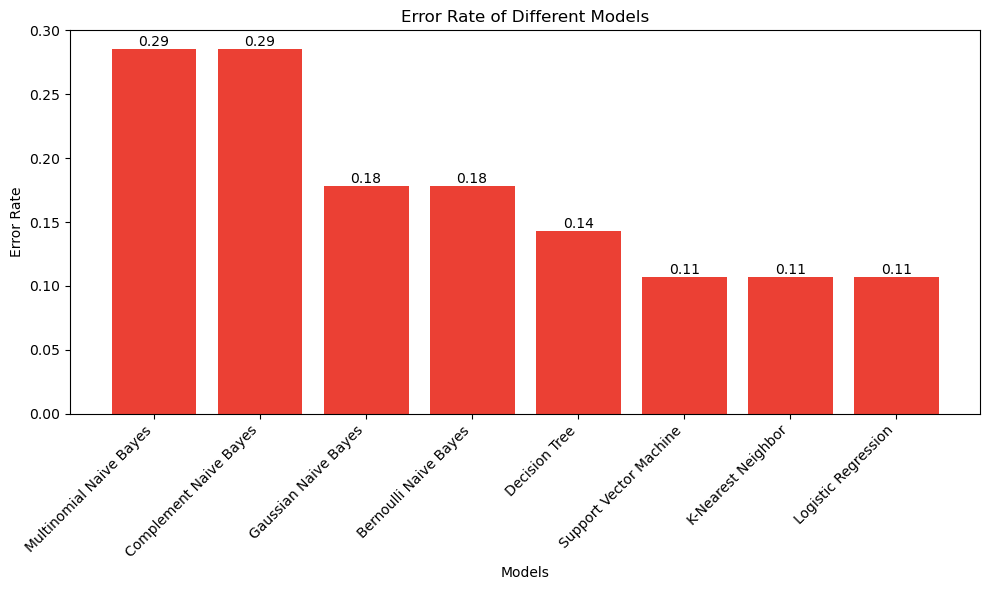

In [20]:
import random

# sort data
sorted_data_by_values = sorted(data.items(), key=lambda x:x[1])
data = dict(sorted_data_by_values)

# extract model names and accuracies from data
models = list(data.keys())
accuracies = list(data.values())

# calculate errors by subtracting accuracies from 1
errors = [1 - accuracy for accuracy in accuracies]

# Create bar plot with random colors
plt.figure(figsize=(10, 6))
bars = plt.bar(models, errors, color='#eb4034')

# Add title and labels
plt.title('Error Rate of Different Models')
plt.xlabel('Models')
plt.ylabel('Error Rate')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add data labels on top of bars
for bar, error in zip(bars, errors):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{error:.2f}', 
             ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()